The goal of this analysis is to calculate the Customer Lifetime Value (CLV) for customers in the dataset and use it to identify the most valuable customers. This information can then be used to develop targeted marketing strategies, optimize resource allocation, and improve customer retention.

**Steps to Perform CLV Analysis**

* *Load and Clean the Data:* Load the dataset and perform data cleaning by removing any irrelevant or erroneous entries.
* *Calculate RFM Metrics:* Compute Recency, Frequency, and Monetary (RFM) values for each customer to understand their purchasing behavior.
* *Compute CLV Components:* Calculate the Average Purchase Value (APV) and Purchase Frequency (PF) to understand the value and frequency of purchases.
* *Calculate CLV:* Use the APV, PF, and an assumed customer lifespan to calculate the CLV for each customer.
* *Interpret Results:* Segment customers based on their CLV scores and derive actionable insights to enhance business strategy.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rfm = pd.read_csv(r"D:\Portfolio Github\customer_purchase_behavior\rfm_score_segment.csv", index_col=0 )
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,66,15,810.40,3,5,3,353,Potential Loyalists
1,12347.0,2,2,1323.32,5,2,4,524,Needing Attention
2,12348.0,73,1,222.16,2,1,1,211,At Risk
3,12349.0,42,4,2695.29,3,3,5,335,Potential Loyalists
4,12351.0,10,1,300.93,5,1,2,512,At Risk


In [3]:
# Calculate average purchase value and purchase frequency
rfm['APV'] = rfm['Monetary'] / rfm['Frequency']
rfm['PF'] = rfm['Frequency'] / rfm.shape[0]

In [4]:
df = pd.read_excel(r"D:\Portfolio Github\customer_purchase_behavior\online_retail_II.xlsx", sheet_name = "Year 2009-2010" )
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Group by CustomerID and calculate first and last purchase dates
purchase_dates = df.groupby('Customer ID')['InvoiceDate'].agg(['min', 'max']).reset_index()

# Rename columns for clarity
purchase_dates.columns = ['Customer ID', 'FirstPurchaseDate', 'LastPurchaseDate']

In [6]:
# Calculate the lifespan for each customer (in days)
purchase_dates['LifespanDays'] = (purchase_dates['LastPurchaseDate'] - purchase_dates['FirstPurchaseDate']).dt.days

purchase_dates[purchase_dates['LifespanDays'] != 0]

,Customer ID,FirstPurchaseDate,LastPurchaseDate,LifespanDays
0,12346.0,2009-12-14 08:34:00,2010-10-04 16:33:00,294
1,12347.0,2010-10-31 14:20:00,2010-12-07 14:57:00,37
3,12349.0,2009-12-04 12:49:00,2010-10-28 08:23:00,327
5,12352.0,2010-11-12 10:20:00,2010-11-29 10:07:00,16
8,12356.0,2010-10-11 09:42:00,2010-11-24 12:24:00,44
...,...,...,...,...
4376,18280.0,2010-11-10 15:51:00,2010-11-24 12:59:00,13
4378,18283.0,2010-02-19 17:16:00,2010-11-22 15:30:00,275
4379,18284.0,2010-10-04 11:33:00,2010-10-06 12:31:00,2
4381,18286.0,2009-12-16 10:45:00,2010-08-20 11:57:00,247


In [7]:
rfm.shape

(4383, 11)

In [8]:
purchase_dates.shape

(4383, 4)

In [9]:
rfm = rfm.merge(purchase_dates, on= "Customer ID", how="inner")

In [10]:
# Calculate CLV
rfm['CLV'] = rfm['APV'] * rfm['PF'] * rfm['LifespanDays']


In [11]:
rfm.shape

(4383, 15)

In [12]:
# Apply qcut with duplicates='drop'
quantiles, bin_edges = pd.qcut(rfm['CLV'], q=4, retbins=True, duplicates='drop')

# Determine the number of unique bins
num_bins = len(bin_edges) - 1

# Adjust labels based on the number of bins
if num_bins == 4:
    labels = ['Low', 'Moderate', 'High', 'Very High']
elif num_bins == 3:
    labels = ['Low', 'Moderate', 'High']
elif num_bins == 2:
    labels = ['Low', 'High']
else:
    labels = ['Unique']

# Segment customers based on CLV
rfm['Segment_CLV'] = pd.qcut(rfm['CLV'], q=num_bins, labels=labels, duplicates='drop')

# Display segmented customers
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,APV,PF,FirstPurchaseDate,LastPurchaseDate,LifespanDays,CLV,Segment_CLV
0,12346.0,66,15,810.40,3,5,3,353,Potential Loyalists,54.026667,0.003422,2009-12-14 08:34:00,2010-10-04 16:33:00,294,54.359480,High
1,12347.0,2,2,1323.32,5,2,4,524,Needing Attention,661.660000,0.000456,2010-10-31 14:20:00,2010-12-07 14:57:00,37,11.171079,Moderate
2,12348.0,73,1,222.16,2,1,1,211,At Risk,222.160000,0.000228,2010-09-27 14:59:00,2010-09-27 14:59:00,0,0.000000,Low
3,12349.0,42,4,2695.29,3,3,5,335,Potential Loyalists,673.822500,0.000913,2009-12-04 12:49:00,2010-10-28 08:23:00,327,201.085975,High
4,12351.0,10,1,300.93,5,1,2,512,At Risk,300.930000,0.000228,2010-11-29 15:23:00,2010-11-29 15:23:00,0,0.000000,Low


C:\Users\SHUCHISMITA MALLICK\AppData\Local\Temp\ipykernel_13656\506236528.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment_CLV', palette='viridis')


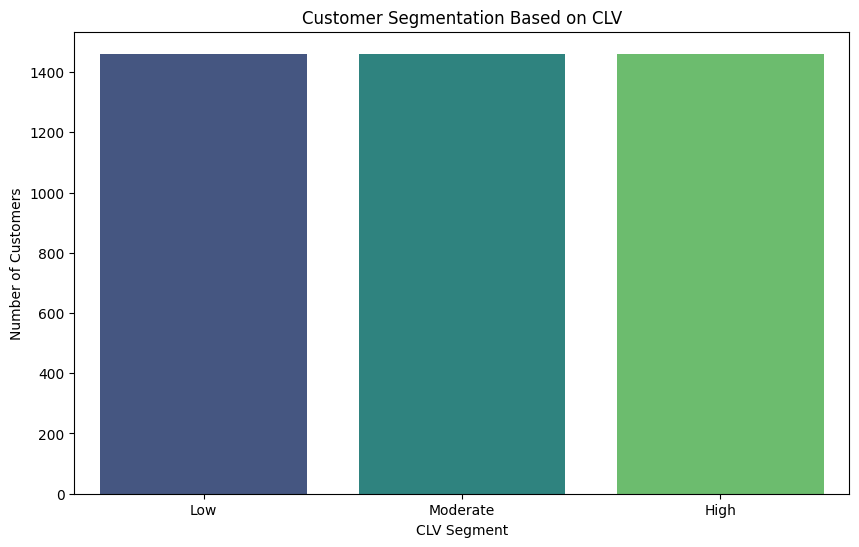

In [13]:
# Visualize the segmentation
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Segment_CLV', palette='viridis')
plt.title('Customer Segmentation Based on CLV')
plt.xlabel('CLV Segment')
plt.ylabel('Number of Customers')
plt.show()

In [16]:
# Group by RFM Segment and CLV Segment to count customers
rfm_clv_analysis = rfm.groupby(['Segment', 'Segment_CLV']).size().reset_index(name='CustomerCount')

rfm_clv_analysis


,Segment,Segment_CLV,CustomerCount
0,At Risk,Low,1303
1,At Risk,Moderate,296
2,At Risk,High,16
3,Champions,Low,0
4,Champions,Moderate,2
5,Champions,High,357
6,Loyal Customers,Low,1
7,Loyal Customers,Moderate,29
8,Loyal Customers,High,302
9,Needing Attention,Low,148


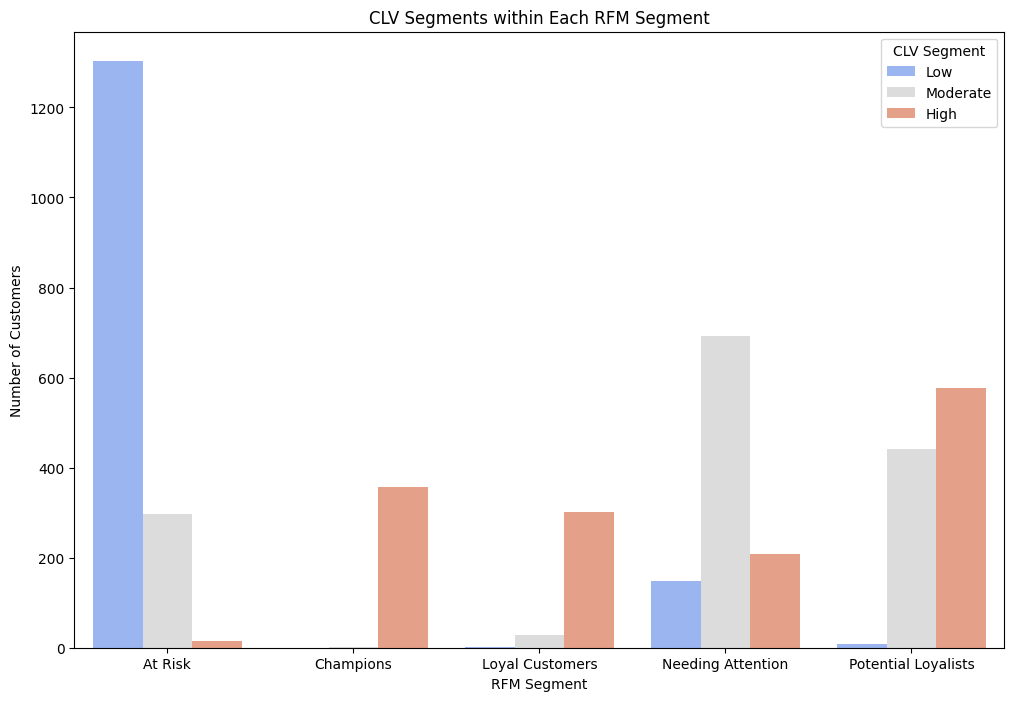

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(data=rfm_clv_analysis, x='Segment', y='CustomerCount', hue='Segment_CLV', palette='coolwarm')
plt.title('CLV Segments within Each RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.legend(title='CLV Segment')
plt.show()


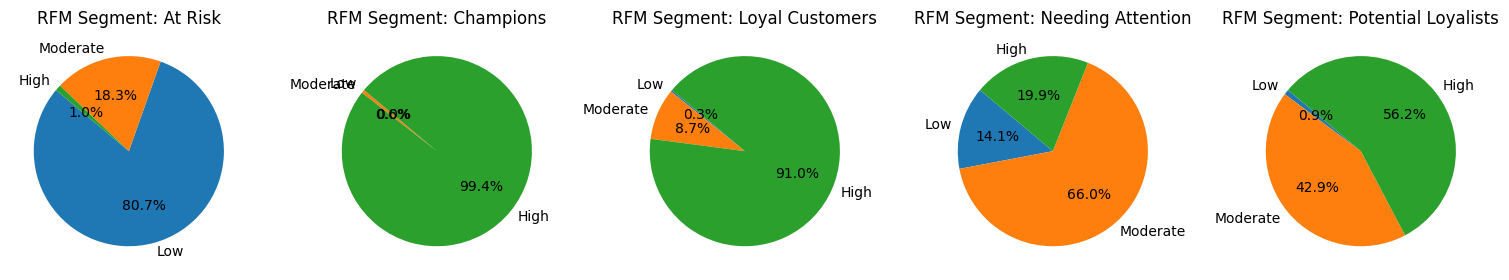

In [19]:
# Plot pie charts for each RFM Segment
unique_segments = rfm_clv_analysis['Segment'].unique()

fig, axes = plt.subplots(1, len(unique_segments), figsize=(15, 5))

for i, segment in enumerate(unique_segments):
    segment_data = rfm_clv_analysis[rfm_clv_analysis['Segment'] == segment]
    axes[i].pie(segment_data['CustomerCount'], labels=segment_data['Segment_CLV'], autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'RFM Segment: {segment}')

plt.tight_layout()
plt.show()

C:\Users\SHUCHISMITA MALLICK\AppData\Local\Temp\ipykernel_13656\2560401199.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  rfm_clv_analysis['Percentage'] = rfm_clv_analysis.groupby('Segment')['CustomerCount'].apply(lambda x: 100 * x / x.sum())


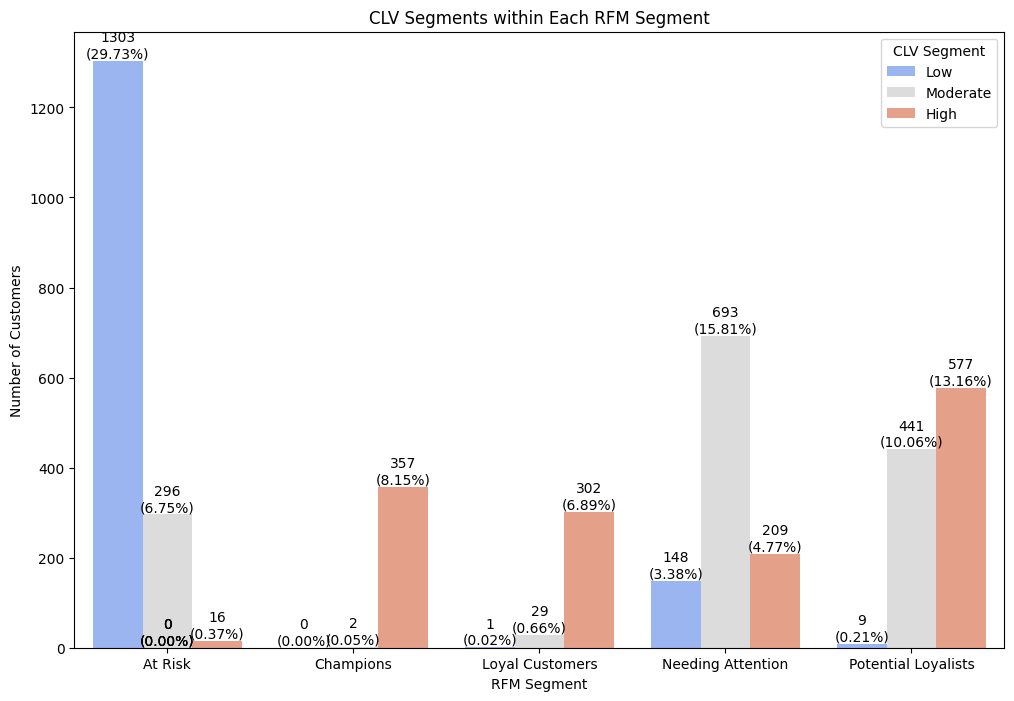

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming rfm_clv_analysis contains the customer count per RFM and CLV segment

# Calculate total customers for each RFM segment to determine percentages
rfm_clv_analysis['Percentage'] = rfm_clv_analysis.groupby('Segment')['CustomerCount'].apply(lambda x: 100 * x / x.sum())

# Create the bar plot
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=rfm_clv_analysis, x='Segment', y='CustomerCount', hue='Segment_CLV', palette='coolwarm')

# Adding percentages on top of the bars
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.text(
        p.get_x() + p.get_width() / 2.,  # X position
        height,  # Y position (top of the bar)
        f'{height:.0f}\n({(height / rfm_clv_analysis["CustomerCount"].sum() * 100):.2f}%)',  # Value and percentage
        ha="center",  # Center the text horizontally
        va='bottom'  # Place the text at the bottom of the bar
    )

# Customizing plot
plt.title('CLV Segments within Each RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.legend(title='CLV Segment')
plt.show()
